## Purpose

Cluster time series using DBSCAN

In [21]:
import os 
import sys
import numpy as np
from collections import defaultdict
import CAN_objects.aid_message
import matplotlib.pyplot as plt


actt_path = os.path.join(os.path.join(os.path.expanduser("~"), "Projects", "CAN", "actt"))
os.chdir(actt_path)
sys.path.insert(0, "src") # add src folder to path so that files from this folder can be imported

from generalFunctions import unpickle
import subprocess

import importlib
importlib.reload(CAN_objects.aid_message)
from init_cancapture_from_canlog import init_cancap
import json
import seaborn as sns
import pandas as pd

from CAN_objects.capture import MappedCapture, MatchedCapture
import math
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, linkage, fcluster

from pprint import pprint
from sklearn.metrics.cluster import normalized_mutual_info_score

from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

import glob
from tqdm import tqdm
import itertools
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, spearmanr
from sklearn.preprocessing import normalize, scale, MinMaxScaler, StandardScaler

from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors

from statistics import mode
from bisect import bisect_left

## Enable the Use of Functions From the Detect Repo

In [22]:
# sys.path.insert(0, "/home/cades/Projects/CAN/detect/") # add detect folder to path so that files from this folder can be imported
sys.path.insert(0, "/home/cloud/Projects/CAN/detect/") # add detect folder to path so that files from this folder can be imported
import signal_based_preprocess_functions
print(os.getcwd())

/home/cloud/Projects/CAN/actt


## Functions

In [23]:
def from_capture_to_time_series(cap, ground_truth_dbc_path):
    
    signal_multivar_ts, timepts, aid_signal_tups = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap, ground_truth_dbc_path)

    return signal_multivar_ts, timepts, aid_signal_tups


def from_captures_to_time_series(cap_1, cap_2, ground_truth_dbc_path):
        
    signal_multivar_ts_1, timepts_1, aid_signal_tups_1 = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap_1, ground_truth_dbc_path)
    signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap_2, ground_truth_dbc_path)

    return signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2


def from_single_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df_1 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_1[:,index] for index, tup in enumerate(aid_signal_tups_1)})
    display(df_1)

    # Remove columns with constant values
    df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()] 
    # display(df_1)
    # df_1.dtypes
    
    df_1_scaled = normalize(df_1) # scale
    df_1_scaled = pd.DataFrame(df_1_scaled, columns=df_1.columns)
    df_1 = df_1_scaled
    display(df_1)

    # Compute correlation matrix
    corr_matrix_1 = df_1.corr(method="pearson")
    # display(corr_matrix_1)
    # display(corr_matrix_1.loc[["1760_0", "1760_1", "1760_2", "1760_3"], ["1760_0", "1760_1", "1760_2", "1760_3"]])
    signal_names_1 = corr_matrix_1.columns.values

    
    return corr_matrix_1, signal_names_1


def from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df_1 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_1[:,index] for index, tup in enumerate(aid_signal_tups_1)})
    display(df_1)

    # Remove columns with constant values
    df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()] 
    # display(df_1)
    # df_1.dtypes
    
    df_1_scaled = normalize(df_1) # scale
    df_1_scaled = pd.DataFrame(df_1_scaled, columns=df_1.columns)
    df_1 = df_1_scaled
    display(df_1)

    # Compute correlation matrix
    corr_matrix_1 = df_1.corr(method="pearson")
    # display(corr_matrix_1)
    # display(corr_matrix_1.loc[["1760_0", "1760_1", "1760_2", "1760_3"], ["1760_0", "1760_1", "1760_2", "1760_3"]])
    signal_names_1 = corr_matrix_1.columns.values
    # print(len(signal_names_training), signal_names_training)
    
    ##################
    # Second dataframe
    # Convert matrix of time series into a dataframe
    df_2 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_2[:,index] for index, tup in enumerate(aid_signal_tups_2)})
    # display(df)

    # Remove columns with constant values
    df_2 = df_2.loc[:, (df_2 != df_2.iloc[0]).any()] 
    # display(df_2)
    # df_2.dtypes
    
    df_2_scaled = normalize(df_2) # scale
    df_2_scaled = pd.DataFrame(df_2_scaled, columns=df_2.columns)
    df_2 = df_2_scaled
    # display(df_2)

    # Compute correlation matrix
    corr_matrix_2 = df_2.corr(method="pearson")
    # display(corr_matrix_2)
    # display(corr_matrix_2.loc[["1760_0", "1760_1", "1760_2", "1760_3"], ["1760_0", "1760_1", "1760_2", "1760_3"]])
    signal_names_2 = corr_matrix_2.columns.values
    # print(len(signal_names_training), signal_names_training)
    
    signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))
    
    return corr_matrix_1, corr_matrix_2, signal_names_intersection


def compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method):
    
    # Filter correlation matrices by common names
    corr_matrix_1 = corr_matrix_1.loc[signal_names_intersection, signal_names_intersection]
    # display(corr_matrix_1)

    corr_matrix_2 = corr_matrix_2.loc[signal_names_intersection, signal_names_intersection]
    # display(corr_matrix_2)
    
    linkage_matrix_1 = hierarchical_clustering(corr_matrix_1, method=method)
    linkage_matrix_2 = hierarchical_clustering(corr_matrix_2, method=method)
    
    return linkage_matrix_1, linkage_matrix_2


def compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=1.0):
    
    c_1 = Clustering().from_scipy_linkage(linkage_matrix_1, dist_rescaled=True)
    c_2 = Clustering().from_scipy_linkage(linkage_matrix_2, dist_rescaled=True)
    
    return sim.element_sim(c_1, c_2, r=r, alpha=0.9)


def compute_distribution_training(training_captures, ground_truth_dbc_path):
    
    pairs = []
    
    for row in tqdm(range(len(training_captures))):
    
        for column in range(row, len(training_captures)):

            signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = from_captures_to_time_series(training_captures[row], training_captures[column], ground_truth_dbc_path)
            corr_matrix_1, corr_matrix_2, signal_names_intersection = from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2)
            linkage_matrix_1, linkage_matrix_2 = compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method="ward")
            similarity = compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=-5)
            pairs.append([(training_captures[row], training_captures[column]), similarity])

    print(pairs)

    with open(f"./similarity_matrix_training.json", "w") as f:
        json.dump(pairs, f)


def compute_distribution_mixed(training_captures, testing_captures, ground_truth_dbc_path):
    
    pairs = []
    
    for interest_capture in tqdm(training_captures):
        for capture in testing_captures:
        
            signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = from_captures_to_time_series(interest_capture, capture, ground_truth_dbc_path)
            corr_matrix_1, corr_matrix_2, signal_names_intersection = from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2)
            linkage_matrix_1, linkage_matrix_2 = compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method="ward")
            similarity = compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=-5)
            pairs.append([(interest_capture, capture), similarity])
        
    print(pairs)

    with open(f"./similarity_matrix_mixed.json", "w") as f:
        json.dump(pairs, f)


def compute_distribution_testing(testing_captures, ground_truth_dbc_path):
    
    pairs = []
    
    for row in tqdm(range(len(testing_captures))):
    
        for column in range(row, len(testing_captures)):

            signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = from_captures_to_time_series(testing_captures[row], testing_captures[column], ground_truth_dbc_path)
            corr_matrix_1, corr_matrix_2, signal_names_intersection = from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2)
            linkage_matrix_1, linkage_matrix_2 = compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method="ward")
            similarity = compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=-5)
            pairs.append([(testing_captures[row], testing_captures[column]), similarity])

    print(pairs)

    with open(f"./similarity_matrix_testing.json", "w") as f:
        json.dump(pairs, f)


def remove_constant_signals(signal_multivar_ts):
    return signal_multivar_ts[:, ~np.all(signal_multivar_ts[1:] == signal_multivar_ts[:-1], axis=0)]


def partition_time_series(signal_multivar_ts, window_length, offset):
    
    n = signal_multivar_ts.shape[0]
    i = 0
    partition = []
    
    while (i + window_length) < n:
        partition.append(signal_multivar_ts[i: i + window_length,:])
        i = i + offset
        
    if i != n:
        partition.append(signal_multivar_ts[i:n,:])
        
    return partition
    
    
def process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window_length, offset):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts[:,index] for index, tup in enumerate(aid_signal_tups)})
    # display(df)

    # Remove columns with constant values
    df = df.loc[:, (df != df.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_standardized = (df-df.mean())/df.std()
    # display(df_standardized)
    
    # Partition of data frames
    n = df_standardized.shape[0]
    i = 0
    partition = []
    
    while (i + window_length) < n:
        partition.append(df_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition.append(df_standardized.iloc[i:n, :])
        
    return partition


def process_multiple_multivariate_signals(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2, window_length, offset):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df_1 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_1[:,index] for index, tup in enumerate(aid_signal_tups_1)})
    # display(df)
    print(df_1.shape)

    # Remove columns with constant values
    df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_1_standardized = (df_1-df_1.mean())/df_1.std()
    # display(df_2_standardized)
    
    # Partition of data frames
    n = df_1_standardized.shape[0]
    i = 0
    partition_1 = []
    
    while (i + window_length) < n:
        partition_1.append(df_1_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition_1.append(df_1_standardized.iloc[i:n, :])
        
        
    # Second dataframe
    # Convert matrix of time series into a dataframe
    df_2 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_2[:,index] for index, tup in enumerate(aid_signal_tups_2)})
    # display(df)
    print(df_2.shape)

    # Remove columns with constant values
    df_2 = df_2.loc[:, (df_2 != df_2.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_2_standardized = (df_2-df_2.mean())/df_2.std()
    # display(df_2_standardized)
    
    # Partition of data frames
    n = df_2_standardized.shape[0]
    i = 0
    partition_2 = []
    
    while (i + window_length) < n:
        partition_2.append(df_2_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition_2.append(df_2_standardized.iloc[i:n, :])
        
    return partition_1, partition_2


def upper(df):
    '''Returns the upper triangle of a correlation matrix (excluding diagonal).
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df) == np.ndarray)
    except:
        if type(df) == pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    
    return df[mask]



def randomized_test_permutations(m1, m2):
    """Nonparametric permutation testing Monte Carlo"""
    np.random.seed(0)
    rhos = []
    n_iter = 100
    true_rho, _ = spearmanr(upper(m1), upper(m2))
    # matrix permutation, shuffle the groups
    m_ids = list(m1.columns)
    m2_v = upper(m2)
    for iter in range(n_iter):
        np.random.shuffle(m_ids) # shuffle list 
        r, _ = spearmanr(upper(m1.loc[m_ids, m_ids]), m2_v)  
        rhos.append(r)
    perm_p = ((np.sum(np.abs(true_rho) <= np.abs(rhos)))+1)/(n_iter+1) # two-tailed test

    return perm_p


def compute_correlation_matrices(partition):
    
    corr_matrices = []

    for df in partition:

        # Adjust the number of decimals
        df = df.round(decimals=6)
        # Remove columns with constant values
        df = df.loc[:, (df != df.iloc[0]).any()] 

        # Compute correlation matrix
        corr_matrices.append(df.corr(method="pearson"))
        
    return corr_matrices


def compute_similarity_from_correlation_matrices(corr_matrices):
    
    similarities = []
    
    for i in range(len(corr_matrices)-1):

        # print("raw: ", corr_matrices[i].shape, corr_matrices[i+1].shape)

        signal_names_1 = corr_matrices[i].columns.values
        signal_names_2 = corr_matrices[i+1].columns.values
        signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))

        df_1 = corr_matrices[i].loc[signal_names_intersection, signal_names_intersection] 
        df_2 = corr_matrices[i+1].loc[signal_names_intersection, signal_names_intersection]
  
        # print("pro: ", df_1.shape, df_2.shape, "\n")

        similarities.append((df_1.shape[0], spearmanr(upper(df_1), upper(df_2))[0], spearmanr(upper(df_1), upper(df_2))[1]))
        
    return similarities


def compute_similarity_from_multiple_correlation_matrices(corr_matrices_1, corr_matrices_2):
    
    similarities = []
    
    if len(corr_matrices_1) <= len(corr_matrices_2):
        corr_matrices_reference = corr_matrices_1
    else:
        corr_matrices_reference = corr_matrices_2
        
    print(len(corr_matrices_reference))
            
    for i in range(len(corr_matrices_reference)):

        # print("raw: ", corr_matrices[i].shape, corr_matrices[i+1].shape)

        signal_names_1 = corr_matrices_1[i].columns.values
        signal_names_2 = corr_matrices_2[i].columns.values
        signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))

        df_1 = corr_matrices_1[i].loc[signal_names_intersection, signal_names_intersection] 
        df_2 = corr_matrices_2[i].loc[signal_names_intersection, signal_names_intersection]
  
        # print("pro: ", df_1.shape, df_2.shape, "\n")

        # similarities.append((df_1.shape[0], spearmanr(upper(df_1), upper(df_2))[0], spearmanr(upper(df_1), upper(df_2))[1]))
        
        correlation = spearmanr(upper(df_1), upper(df_2))[0]
        p_value = spearmanr(upper(df_1), upper(df_2))[1]
        
        if p_value > 0.05:
            similarities.append((i, correlation, p_value))
        else:
            similarities.append(i)
            
        
    return similarities


def compute_distance_matrix(corr_matrix):

    signal_names = np.array(corr_matrix.columns)

    # display(corr_matrix)

    # compute distance matrix
    # distance_matrix = np.sqrt(2*(1 - corr_matrix.to_numpy())) 
    distance_matrix = 2*(1 - corr_matrix.to_numpy())
    distance_matrix[distance_matrix < 0] = 0
    # display(distance_matrix.shape)
    # display(distance_matrix)

    return signal_names, distance_matrix



def create_time_intervals(start_time, end_time, window, offset):

    intervals = []
    # window = 100*window
    # offset = 0.1*offset
    
    for i in np.arange(start_time, end_time - window + 1, offset, dtype=float):
        intervals.append((i, i + window))

    if i + window < end_time:
        intervals.append((i + offset, end_time))

    return intervals  


def _bisect_left_mod(signal_times, t_interp):
    idx = bisect_left(signal_times,t_interp)
    if idx > 0:
        return idx - 1
    else:
        return 0


def interpolate_time_series(id_dic, timepts):
    interp_vals = []

    for id, signal_dic in id_dic.items():

        for signal_id, payload in signal_dic.items():

            interp_signals = []

            for t in timepts:

                interp_signals.append(payload[1][_bisect_left_mod(payload[0], t)])
                
            interp_vals.append(interp_signals)

    return np.swapaxes(np.vstack(interp_vals), 0, 1)


def dic_to_mv_signal_timeseries(id_dic, max_start_time, min_end_time, min_hz_msgs=10):
    step = 1000/min_hz_msgs # because SynCAN timestamps are in ms

    timepts = np.arange(max_start_time, min_end_time, step) # to endure we have coverage for the time intervals in each of the IDs

    signal_multivar_ts = interpolate_time_series(id_dic, timepts)

    return signal_multivar_ts, timepts


def reformat_synCAN_dataset(file_name, df, read_df=False):
    if read_df == True:
        df_original = pd.read_csv("/home/cloud/Projects/CAN/actt/data/SynCAN-Dataset/" + file_name)
    else:
        df_original = df

    diff_dic = {}
    id_dic = {}
    start_times = []
    end_times = []
    aid_signal_tups = []

    # unique_ids = df_original.sort_values(by=["ID"], ascending=True)["ID"].unique()
    unique_ids = ["id" + str(i) for i in np.arange(1, 11)]
    # print(unique_ids)

    for count_id, id in enumerate(unique_ids, start=1):

        # Dropping missing columns
        df = df_original[df_original["ID"] == id].dropna(axis=1, how="all")
        # display(df)

        # Time range
        times = df[df["ID"] == id].sort_values(by=["Time"], ascending=True)["Time"].to_numpy()
        start, end = times[0], times[-1]
        start_times.append(start)
        end_times.append(end)
        
        # Time intervals
        diffs = np.diff(times)
        modes = mode(diffs)
        
        diff_dic[id] = diffs
        unique = len(np.unique(diffs))

        # print(f"{id}, unique inter-arrival time: {unique}, mode: {modes}") 
        # print(f"start: {start}, end: {end}, duration (min): {(end-start)/60000}\n")
        interval = np.arange(start, end, 100)
        # print(len(interval), interval)

        # Extract signal names
        df = df.loc[:, df.columns.str.startswith("Signal")]
        signal_names = df.columns.to_numpy()
        # print(signal_names)
        
        # Create dictionary of signals
        signal_dic = {}
        for count_signal, signal_name in enumerate(signal_names, start=0):
            values = df[signal_name].to_numpy()
            signal_dic[signal_name] = [times, values]

            #print(count_id, count_signal)
            aid_signal_tups.append((count_id, count_signal))

        id_dic[id] = signal_dic

    max_start_time = np.ceil(max(start_times))
    min_end_time = np.floor(min(end_times))
        
    return id_dic, aid_signal_tups, max_start_time, min_end_time 


def binary_search(number, intervals):
    # intervals.sort()
    mid = len(intervals)//2  # a//b is in python3. Use len(intervals)/2 for python2
    low, high = intervals[mid]

    # print(number, mid, (low, high), "intervals:", intervals)
    
    if number > high and len(intervals) > 2:
        # print("high", intervals[mid+1:])
        return binary_search(number, intervals[mid+1:])
    elif number < low and len(intervals) > 2:
        # print("low", intervals[:mid])
        return binary_search(number, intervals[:mid])
    elif low <= number <= high:
        return True
    else:
        return False
    


## Processing SynCAN Benign Data

In [24]:
df_train1 = pd.read_csv("/home/cloud/Projects/CAN/actt/data/SynCAN-Dataset/train_1.csv")  
df_train2 = pd.read_csv("/home/cloud/Projects/CAN/actt/data/SynCAN-Dataset/train_2.csv", names=["Label", "Time", "ID", "Signal1", "Signal2", "Signal3", "Signal4"])  
df_train3 = pd.read_csv("/home/cloud/Projects/CAN/actt/data/SynCAN-Dataset/train_3.csv", names=["Label", "Time", "ID", "Signal1", "Signal2", "Signal3", "Signal4"])   
df_train4 = pd.read_csv("/home/cloud/Projects/CAN/actt/data/SynCAN-Dataset/train_4.csv", names=["Label", "Time", "ID", "Signal1", "Signal2", "Signal3", "Signal4"]) 

In [25]:
df_training = pd.concat([df_train1, df_train2, df_train3, df_train4], axis=0)

In [26]:
display(df_training)

,Label,Time,ID,Signal1,Signal2,Signal3,Signal4
0,0,2.088413e+03,id5,0.000000,0.958686,NaN,NaN
1,0,2.089554e+03,id8,0.246839,NaN,NaN,NaN
2,0,2.090886e+03,id3,0.200000,1.000000,NaN,NaN
3,0,2.091658e+03,id7,0.063888,0.000000,NaN,NaN
4,0,2.100364e+03,id9,0.449511,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7417429,0,6.210646e+07,id2,0.000000,0.726288,0.206925,NaN
7417430,0,6.210646e+07,id5,0.346017,0.948461,NaN,NaN
7417431,0,6.210646e+07,id3,0.000000,1.000000,NaN,NaN
7417432,0,6.210646e+07,id1,0.721620,0.750000,NaN,NaN


In [27]:
id_dic, aid_signal_tups, max_start_time, min_end_time = reformat_synCAN_dataset(_, df_training, False)
print(aid_signal_tups, max_start_time, min_end_time)

[(1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (4, 0), (5, 0), (5, 1), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (9, 0), (10, 0), (10, 1), (10, 2), (10, 3)] 2123.0 62106440.0


## Interpolate Signals

In [28]:
signal_multivar_ts, timepts = dic_to_mv_signal_timeseries(id_dic, max_start_time, min_end_time, min_hz_msgs=10)

In [29]:
signal_multivar_ts.shape

(621044, 20)

In [30]:
window = signal_multivar_ts.shape[0]
offset = window
partition_training = process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window, offset)

In [31]:
print(len(partition_training))
partition_training[0]

1


,1_0,1_1,2_0,2_1,2_2,3_0,3_1,4_0,5_0,5_1,6_0,6_1,7_0,7_1,8_0,9_0,10_0,10_1,10_2,10_3
0,-5.915819,-0.708589,-0.446372,-5.971535,0.789838,0.291778,0.446376,-0.781199,-2.798591,0.801132,0.75684,-1.573655,-0.273374,0.000209,0.793830,1.923879,1.982973,-1.108059,0.811289,-2.903570
1,-5.915819,0.705992,-0.446372,-5.971535,0.813512,0.291778,0.446376,-0.777028,-2.795463,0.783570,0.75684,-0.541169,-0.268986,0.708229,0.815241,2.106948,2.117963,-0.088009,0.791195,-2.810146
2,-5.915819,1.413282,-0.446372,-5.971535,0.832884,0.877328,0.446376,-0.777028,-2.794681,0.757103,0.75684,0.835478,-0.265474,-1.415833,0.832370,2.086353,2.097371,0.932040,0.771141,-2.824397
3,-5.915819,-0.708589,-0.446372,-5.971535,0.845800,1.462878,0.446376,-0.777028,-2.794681,0.739491,0.75684,-1.573655,-0.262402,0.000209,0.847358,1.958205,1.969245,-1.448075,0.750842,-2.913071
4,-5.915819,0.705992,-0.446372,-5.971535,0.867328,1.462878,0.446376,-0.777028,-2.794681,0.721930,0.75684,-0.541169,-0.257574,0.708229,0.870910,1.669871,1.771727,-0.428026,0.730925,-3.050831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621039,-0.156867,0.705992,-0.446372,-0.152745,0.510242,-1.464873,0.446376,-0.158064,-0.171653,0.780669,0.75684,1.179640,-0.332624,1.416250,0.504780,1.711061,1.639748,1.272056,0.791481,1.018058
621040,-0.168056,-1.415879,-0.446372,-0.162230,0.471557,-0.879323,0.446376,0.029628,0.056656,0.774065,0.75684,-1.229493,-0.340524,-1.415833,0.466240,1.926168,1.873121,-1.108059,0.784163,1.172872
621041,-0.175119,-0.708589,-0.446372,-0.172191,0.430730,-0.879323,0.446376,0.578520,0.480651,0.764008,0.75684,0.147155,-0.347547,0.000209,0.431983,2.052028,2.058446,0.592024,0.772740,1.292658
621042,-0.183372,0.705992,-0.446372,-0.179149,0.383466,-0.293773,0.446376,0.972255,0.847257,0.757504,0.75684,1.179640,-0.358519,1.416250,0.378455,2.104660,2.109534,1.612073,0.765207,1.324039


## Compute Correlation Matrices

In [32]:
corr_matrices_training = compute_correlation_matrices(partition_training)
display(corr_matrices_training[0])

,1_0,1_1,2_0,2_1,2_2,3_0,3_1,4_0,5_0,5_1,6_0,6_1,7_0,7_1,8_0,9_0,10_0,10_1,10_2,10_3
1_0,1.000000,0.005422,-0.036791,0.999981,-0.007432,-0.000048,0.036810,-0.000754,0.348592,-0.032523,-0.032377,-0.012096,-0.037395,-0.016638,-0.007454,0.000672,0.000540,-0.015812,-0.033689,0.721916
1_1,0.005422,1.000000,0.000717,0.005404,-0.000625,-0.003228,-0.000726,0.001467,0.003266,-0.003324,-0.003359,0.014918,0.000587,0.500058,-0.000641,0.002014,0.002033,0.012294,-0.003806,0.005325
2_0,-0.036791,0.000717,1.000000,-0.036720,0.004456,-0.000195,-0.999939,0.000203,-0.012661,0.015914,0.015880,-0.013600,0.977848,0.000267,0.004490,0.002534,0.002559,-0.007819,0.016010,-0.024817
2_1,0.999981,0.005404,-0.036720,1.000000,-0.007382,-0.000049,0.036739,-0.000744,0.348595,-0.032203,-0.032058,-0.012034,-0.037317,-0.016580,-0.007404,0.000745,0.000613,-0.015765,-0.033359,0.721952
2_2,-0.007432,-0.000625,0.004456,-0.007382,1.000000,-0.001339,-0.004403,-0.007451,-0.009552,-0.006376,-0.006432,-0.001311,0.213178,0.002947,0.999894,0.002686,0.017036,-0.002743,-0.007734,-0.003499
3_0,-0.000048,-0.003228,-0.000195,-0.000049,-0.001339,1.000000,0.000199,-0.000026,-0.000044,0.000034,0.000071,-0.000918,-0.000470,-0.002029,-0.001333,-0.001427,-0.001403,0.002058,-0.000050,-0.000995
3_1,0.036810,-0.000726,-0.999939,0.036739,-0.004403,0.000199,1.000000,-0.000188,0.012682,-0.015890,-0.015856,0.013600,-0.977884,-0.000260,-0.004438,-0.002498,-0.002520,0.007816,-0.015984,0.024858
4_0,-0.000754,0.001467,0.000203,-0.000744,-0.007451,-0.000026,-0.000188,1.000000,0.936709,0.002356,0.002173,0.002127,-0.001462,-0.006297,-0.007428,-0.007974,-0.008165,0.000778,0.001701,-0.006123
5_0,0.348592,0.003266,-0.012661,0.348595,-0.009552,-0.000044,0.012682,0.936709,1.000000,-0.009134,-0.009254,-0.002226,-0.014427,-0.011721,-0.009538,-0.007221,-0.007441,-0.004794,-0.010157,0.246441
5_1,-0.032523,-0.003324,0.015914,-0.032203,-0.006376,0.000034,-0.015890,0.002356,-0.009134,1.000000,0.999716,-0.021419,0.014080,0.009082,-0.006356,-0.003540,-0.003608,-0.008361,0.998365,-0.025902


In [33]:
print(len(corr_matrices_training))
#corr_matrices_training[0]
corr_sample_training = upper(corr_matrices_training[0])

1


In [34]:
corr_matrices_training[0].columns.values

array(['1_0', '1_1', '2_0', '2_1', '2_2', '3_0', '3_1', '4_0', '5_0',
       '5_1', '6_0', '6_1', '7_0', '7_1', '8_0', '9_0', '10_0', '10_1',
       '10_2', '10_3'], dtype=object)

## Computing Distance Matrix

In [35]:
# https://stats.stackexchange.com/questions/165194/using-correlation-as-distance-metric-for-hierarchical-clustering

# distance_matrix = 1 - corr_matrix.to_numpy()
# distance_matrix = np.sqrt(2*(1 - corr_matrix.to_numpy())) 
distance_matrix = 2*(1 - corr_matrices_training[0].to_numpy())
distance_matrix[distance_matrix < 0] = 0
display(distance_matrix.shape)
display(distance_matrix)

(20, 20)

array([[0.00000000e+00, 1.98915598e+00, 2.07358125e+00, 3.82253607e-05,
        2.01486398e+00, 2.00009599e+00, 1.92638068e+00, 2.00150831e+00,
        1.30281636e+00, 2.06504625e+00, 2.06475364e+00, 2.02419244e+00,
        2.07479006e+00, 2.03327554e+00, 2.01490879e+00, 1.99865605e+00,
        1.99892060e+00, 2.03162457e+00, 2.06737837e+00, 5.56168978e-01],
       [1.98915598e+00, 0.00000000e+00, 1.99856516e+00, 1.98919159e+00,
        2.00124927e+00, 2.00645521e+00, 2.00145152e+00, 1.99706559e+00,
        1.99346821e+00, 2.00664889e+00, 2.00671732e+00, 1.97016466e+00,
        1.99882634e+00, 9.99883960e-01, 2.00128168e+00, 1.99597232e+00,
        1.99593498e+00, 1.97541211e+00, 2.00761142e+00, 1.98935081e+00],
       [2.07358125e+00, 1.99856516e+00, 0.00000000e+00, 2.07344031e+00,
        1.99108875e+00, 2.00039088e+00, 3.99987871e+00, 1.99959395e+00,
        2.02532198e+00, 1.96817224e+00, 1.96824034e+00, 2.02719929e+00,
        4.43032702e-02, 1.99946597e+00, 1.99101941e+00, 1.9949

In [36]:
print(np.min(distance_matrix), np.max(distance_matrix))

0.0 3.9998787097293143


## Clustering with DBSCAN

### Finding Optimal eps

In [37]:
neighb = NearestNeighbors(n_neighbors=2, metric="precomputed")
nbrs = neighb.fit(distance_matrix)

In [38]:
distances, indices = nbrs.kneighbors(distance_matrix)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

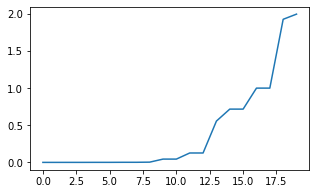

In [39]:
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [40]:
DBSCAN_clustering = DBSCAN(eps=1, min_samples=1, metric="precomputed")
DBSCAN_clustering.fit(distance_matrix)

DBSCAN(eps=1, metric='precomputed', min_samples=1)

## DBSCAN Clustering Output

In [41]:
DBSCAN_clustering.labels_

array([0, 1, 2, 0, 3, 4, 5, 6, 6, 7, 7, 8, 2, 1, 3, 0, 0, 8, 7, 0])

In [42]:
print(len(DBSCAN_clustering.labels_), np.count_nonzero(DBSCAN_clustering.labels_ == -1))

20 0


In [43]:
DBSCAN_clustering.labels_.max()

8

## Partition Time Series Attack

In [44]:
file_name = "test_normal.csv"

id_dic, aid_signal_tups, max_start_time, min_end_time = reformat_synCAN_dataset(file_name, _, True)
print(aid_signal_tups, max_start_time, min_end_time)

[(1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (4, 0), (5, 0), (5, 1), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (9, 0), (10, 0), (10, 1), (10, 2), (10, 3)] 85508963.0 90009365.0


## Interpolate Signals

In [45]:
signal_multivar_ts, timepts = dic_to_mv_signal_timeseries(id_dic, max_start_time, min_end_time, min_hz_msgs=10)

## Stream a Single Attack

In [46]:
window = 10
offset = 10

DBSCAN_clustering = DBSCAN(eps=1, min_samples=1, metric="precomputed")

partition_testing = process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window, offset) # Partition time series
print("intervals: ", len(partition_testing))

# display(partition_testing[0])
# display(partition_testing[1])

corr_matrices_testing = compute_correlation_matrices(partition_testing) # Compute Correlations

total_length = (int(np.ceil(timepts[-1])) - int(np.ceil(timepts[0])))/1000
print("total length (s): ", total_length) 

intervals_testing = create_time_intervals(max_start_time, min_end_time, window=window*100, offset=offset*100)
print(len(intervals_testing))

tp, fp, fn, tn = 0, 0, 0, 0

for index_interval in tqdm(range(len(intervals_testing))):

    # print("Interval: ", intervals_testing[index_interval])

    # print(np.isnan(corr_matrices_testing[index_interval]).any().any())
    # print((corr_matrices_testing[index_interval] < 0).any().any())

    # print(corr_matrices_testing[index_interval].shape)
    signal_names, distance_matrix = compute_distance_matrix(corr_matrices_testing[index_interval])
    # print(np.isnan(distance_matrix).any().any())
    # print((distance_matrix < 0))
    # display(distance_matrix[distance_matrix < 0])
    # print(type(signal_names), signal_names)
    
    DBSCAN_clustering.fit(distance_matrix)

    clustering_labels = DBSCAN_clustering.labels_
    
    unique_clustering_labels = np.unique(clustering_labels)

    # print(len(clustering_labels), len(unique_clustering_labels), clustering_labels)

    max_error_all_clusters = []

    for cluster_id in (unique_clustering_labels):
        
        index_of_interest = np.argwhere(clustering_labels == cluster_id).flatten()
        # print(cluster_id, len(index_of_interest), index_of_interest)
        # print(signal_names[index_of_interest])
        
        if len(index_of_interest) >= 2: # Check only clusters with at least two elements

            pd_corr_matrix = pd.DataFrame(corr_matrices_testing[index_interval], index=signal_names, columns=signal_names)
            # display(pd_distance_matrix)
            matrix_of_interest = pd_corr_matrix.loc[signal_names[index_of_interest], signal_names[index_of_interest]]
            # display(matrix_of_interest)

            upper_matrix_of_interest = upper(matrix_of_interest)
            # display(upper_matrix_of_interest)

            mean_cluster = np.mean(upper_matrix_of_interest)
            std_cluster = np.std(upper_matrix_of_interest)
            # print(std_cluster)

            if std_cluster != 0:

                error_cluster = np.absolute(upper_matrix_of_interest - mean_cluster)
                error_cluster = error_cluster/std_cluster
                max_error_cluster = np.max(error_cluster)
                
                max_error_all_clusters.append(max_error_cluster)

            # break

    mean_max_error_all_clusters = np.mean(max_error_all_clusters)
    std_max_error_all_clusters = np.std(max_error_all_clusters)
    
    # print("mean: ", mean_max_error_all_clusters, "std: ", std_max_error_all_clusters, "dist: ", max_error_all_clusters)
    
    # break

    if mean_max_error_all_clusters > 2.0: # positive detection
        # if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
        #        or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
        #            or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
        #     tp += 1
        # else:
        fp += 1
    else: # negative detection
        # if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
        #        or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
        #            or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
        #     fn += 1
        # else:
        tn += 1
            
# precision
if tp + fp != 0:            
    precision = tp/(tp + fp)
else:
    precision = np.nan

# recall
if tp + fn != 0:
    recall = tp/(tp + fn)
else:
    recall = np.nan

# f1
if precision + recall != 0:
    f1 = 2*((precision*recall)/(precision + recall))

else:
    f1 = np.nan

# fpr
if fp + tn != 0:
    fpr = fp/(fp + tn)
else:
    fpr = np.nan

# fnr
if fn + tp != 0:
    fnr = fn/(fn + tp)
else:
    fnr = np.nan

# mcc
if (tp+fp == 0) or (tp+fn == 0) or (tn+fp == 0) or (tn+fn == 0):
    mcc = (tp*tn) - (fp*fn)
else:
    mcc = (tp*tn - fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
print(f"precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, fpr: {fpr:.3f}, fnr: {fnr:.3f}, mcc: {mcc:.3f}")
print(f"positive_intervals: {tp+fn:.3f}, negative_intervals: {tn+fp:.3f}\n")

intervals:  4501
total length (s):  4500.4
4501


100%|██████████| 4501/4501 [00:17<00:00, 253.77it/s]

tp: 0, tn: 3615, fp: 886, fn: 0
precision: 0.000, recall: nan, f1: nan, fpr: 0.197, fnr: nan, mcc: 0.000
positive_intervals: 0.000, negative_intervals: 4501.000



## Hypothesis Testing (All Attacks)

In [47]:
with open("/home/cloud/Projects/CAN/actt/data/SynCAN-Dataset/" + "dic_attack_intervals.json", "r") as fp:
    attack_metadata = json.load(fp)

attack_metadata_keys = list(attack_metadata.keys())
display(attack_metadata_keys)

['test_plateau.csv',
 'test_playback.csv',
 'test_suppress.csv',
 'test_flooding.csv',
 'test_continuous.csv']

In [48]:
display(attack_metadata['test_plateau.csv'])

for interval in attack_metadata['test_plateau.csv']:
    print(interval[1] - interval[0])

#attack_metadata['test_plateau.csv'][0][1] - attack_metadata['test_plateau.csv'][0][0]

[[67537573.9491, 67543212.5544],
 [67583022.5544, 67587191.7058],
 [67626329.2547, 67631726.6324],
 [67659992.2329, 67664968.7447],
 [67705122.5544, 67711720.6978],
 [67748279.3292, 67755660.0302],
 [67797168.6874, 67805239.2455],
 [67838863.9985, 67845463.3372],
 [67868300.0494, 67872810.3555],
 [67909407.8584, 67914702.5544],
 [67936260.229, 67944196.2129],
 [67983217.4205, 67987670.4139],
 [68018806.2129, 68026993.2948],
 [68064918.2239, 68073030.5126],
 [68109892.4205, 68114887.1873],
 [68138626.2129, 68143842.5544],
 [68174908.4883, 68180262.5613],
 [68203715.4139, 68211634.3061],
 [68246468.0408, 68253966.8615],
 [68293417.1322, 68298532.9226],
 [68337555.975, 68342595.2881],
 [68377306.2129, 68385612.5544],
 [68412650.4139, 68419489.8597],
 [68442728.2221, 68448157.4205],
 [68481817.7363, 68489692.4205],
 [68528347.4205, 68535500.8989],
 [68565253.7535, 68572062.4963],
 [68599498.8265, 68606396.07],
 [68633023.7535, 68639802.7876],
 [68675342.2033, 68682286.4468],
 [68707568.877

5638.6052999943495
4169.151399999857
5397.377700001001
4976.511800006032
6598.143399998546
7380.701000005007
8070.558100000024
6599.338699996471
4510.306099995971
5294.695999994874
7935.983899995685
4452.993400007486
8187.081900000572
8112.288699999452
4994.766800001264
5216.3414999991655
5354.072999998927
7918.8921999931335
7498.820699989796
5115.790399998426
5039.313100010157
8306.341499999166
6839.4457999914885
5429.198399990797
7874.684199988842
7153.47840000689
6808.74279999733
6897.243499994278
6779.03409999609
6944.243499994278
5189.434999987483
6553.150600001216
5218.966000005603
7857.902500003576
5728.206100001931
6704.57840000093
4287.4733999967575
6389.856299996376
6014.659199997783
6719.441699996591
7991.9201999902725
6912.715599998832
8294.92460000515
8294.0298999995
5666.956000000238
7213.631999999285
5339.006999999285
6509.659000009298
7288.28710000217
8078.469899997115
7527.224399998784
5069.127599999309
7268.0162999928
5699.340099990368
6812.177599996328
4273.050600007

## Stream All Attacks

In [49]:
window = 10
offset = 10

DBSCAN_clustering = DBSCAN(eps=1, min_samples=1, metric="precomputed")

for index_attack in range(len(attack_metadata_keys)):

    print("Processing: ", attack_metadata_keys[index_attack])

    # signal_multivar_ts, timepts, aid_signal_tups = from_capture_to_time_series(testing_captures[index_attack], ground_truth_dbc_path) 

    id_dic, aid_signal_tups, max_start_time, min_end_time = reformat_synCAN_dataset(attack_metadata_keys[index_attack], _, True)
    signal_multivar_ts, timepts = dic_to_mv_signal_timeseries(id_dic, max_start_time, min_end_time, min_hz_msgs=10)

    partition_testing = process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window, offset) # Partition time series
    print("intervals: ", len(partition_testing))

    # display(partition_testing[0])
    # display(partition_testing[1])

    corr_matrices_testing = compute_correlation_matrices(partition_testing) # Compute Correlations
    # display(corr_matrices_testing)

    total_length = (int(np.ceil(timepts[-1])) - int(np.ceil(timepts[0])))/1000
    print("total length (s): ", total_length) 

    intervals_testing = create_time_intervals(max_start_time, min_end_time, window=window*100, offset=offset*100)
    print(len(intervals_testing))

    tp, fp, fn, tn = 0, 0, 0, 0

    for index_interval in range(len(intervals_testing)):

        # print("Interval: ", intervals_testing[index_interval])
        # print(index_interval)

        # print(np.isnan(corr_matrices_testing[index_interval]).any().any())
        # print((corr_matrices_testing[index_interval] < 0).any().any())

        # print(corr_matrices_testing[index_interval].shape)
        signal_names, distance_matrix = compute_distance_matrix(corr_matrices_testing[index_interval])
        # print(np.isnan(distance_matrix).any().any())
        # print((distance_matrix < 0))
        # display(distance_matrix[distance_matrix < 0])
        # print(type(signal_names), signal_names)

        # if index_interval == 934:
        #     display(intervals_testing[index_interval])
        #     display(partition_testing[index_interval])
        #     partition_testing[index_interval].to_csv("/home/cloud/Projects/CAN/actt/data/weird_data_frame.csv")
        #     display(corr_matrices_testing[index_interval])
        #     display(distance_matrix)
        
        
        DBSCAN_clustering.fit(distance_matrix)

        clustering_labels = DBSCAN_clustering.labels_
        
        unique_clustering_labels = np.unique(clustering_labels)

        # print(len(clustering_labels), len(unique_clustering_labels), clustering_labels)

        max_error_all_clusters = []

        for cluster_id in (unique_clustering_labels):
            
            index_of_interest = np.argwhere(clustering_labels == cluster_id).flatten()
            # print(cluster_id, len(index_of_interest), index_of_interest)
            # print(signal_names[index_of_interest])
            
            if len(index_of_interest) >= 2 and cluster_id != -1: # Check only clusters with at least two elements that are NOT outliers

                pd_corr_matrix = pd.DataFrame(corr_matrices_testing[index_interval], index=signal_names, columns=signal_names)
                # display(pd_distance_matrix)
                matrix_of_interest = pd_corr_matrix.loc[signal_names[index_of_interest], signal_names[index_of_interest]]
                # display(matrix_of_interest)

                upper_matrix_of_interest = upper(matrix_of_interest)
                # display(upper_matrix_of_interest)

                mean_cluster = np.mean(upper_matrix_of_interest)
                std_cluster = np.std(upper_matrix_of_interest)
                # print(std_cluster)

                if std_cluster != 0:

                    error_cluster = np.absolute(upper_matrix_of_interest - mean_cluster)
                    error_cluster = error_cluster/std_cluster
                    max_error_cluster = np.max(error_cluster)
                    
                    max_error_all_clusters.append(max_error_cluster)

                # break

        mean_max_error_all_clusters = np.mean(max_error_all_clusters)
        std_max_error_all_clusters = np.std(max_error_all_clusters)
        
        # print("mean: ", mean_max_error_all_clusters, "std: ", std_max_error_all_clusters, "dist: ", max_error_all_clusters)
        
        # break

        if mean_max_error_all_clusters > 2.0: # positive detection
            # if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
            #     or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
            #         or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
            #     tp += 1
            # else:
            #     fp += 1
            if (binary_search(intervals_testing[index_interval][0], attack_metadata[attack_metadata_keys[index_attack]])) or (binary_search(intervals_testing[index_interval][1], attack_metadata[attack_metadata_keys[index_attack]])):
                tp += 1
            else:
                fp += 1
        else: # negative detection
            # if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
            #     or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
            #         or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
            #     fn += 1
            # else:
            #     tn += 1
            if (binary_search(intervals_testing[index_interval][0], attack_metadata[attack_metadata_keys[index_attack]])) or (binary_search(intervals_testing[index_interval][1], attack_metadata[attack_metadata_keys[index_attack]])):
                fn += 1
            else:
                tn += 1
                
    # precision
    if tp + fp != 0:            
        precision = tp/(tp + fp)
    else:
        precision = np.nan

    # recall
    if tp + fn != 0:
        recall = tp/(tp + fn)
    else:
        recall = np.nan

    # f1
    if precision + recall != 0:
        f1 = 2*((precision*recall)/(precision + recall))

    else:
        f1 = np.nan

    # fpr
    if fp + tn != 0:
        fpr = fp/(fp + tn)
    else:
        fpr = np.nan

    # fnr
    if fn + tp != 0:
        fnr = fn/(fn + tp)
    else:
        fnr = np.nan

    # mcc
    if (tp+fp == 0) or (tp+fn == 0) or (tn+fp == 0) or (tn+fn == 0):
        mcc = (tp*tn) - (fp*fn)
    else:
        mcc = (tp*tn - fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

    print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
    print(f"precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, fpr: {fpr:.3f}, fnr: {fnr:.3f}, mcc: {mcc:.3f}")
    print(f"positive_intervals: {tp+fn:.3f}, negative_intervals: {tn+fp:.3f}\n")

    # break

Processing:  test_plateau.csv
intervals:  4501
total length (s):  4500.4
4501
tp: 145, tn: 3096, fp: 654, fn: 606
precision: 0.181, recall: 0.193, f1: 0.187, fpr: 0.174, fnr: 0.807, mcc: 0.018
positive_intervals: 751.000, negative_intervals: 3750.000

Processing:  test_playback.csv
intervals:  4501
total length (s):  4500.4
4501
tp: 115, tn: 3305, fp: 733, fn: 348
precision: 0.136, recall: 0.248, f1: 0.175, fpr: 0.182, fnr: 0.752, mcc: 0.052
positive_intervals: 463.000, negative_intervals: 4038.000

Processing:  test_suppress.csv
intervals:  4501
total length (s):  4500.4
4501
tp: 159, tn: 3005, fp: 633, fn: 704
precision: 0.201, recall: 0.184, f1: 0.192, fpr: 0.174, fnr: 0.816, mcc: 0.011
positive_intervals: 863.000, negative_intervals: 3638.000

Processing:  test_flooding.csv
intervals:  4501
total length (s):  4500.4
4501
tp: 104, tn: 3240, fp: 625, fn: 532
precision: 0.143, recall: 0.164, f1: 0.152, fpr: 0.162, fnr: 0.836, mcc: 0.002
positive_intervals: 636.000, negative_intervals: